<a href="https://colab.research.google.com/github/jinyingtld/python/blob/main/AI6126_tutorial7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Editing 
In this tutorial, we will get to know:
* basic knowledge regarding image-to-image generation and image style transfer.
* two classic image-to-image translation methods - pix2pix (with paired training data) and CycleGAN (with unpaired training data).
* train pix2pix and CycleGAN
* perform inference with a pretrained models.




## PART I Image-to-Image Translation

### Introduction
Let's first recap some background knowledge about image-to-image translation.
Image-to-image translation usually synthesizes images from another set of images. Image-to-image translation tasks can also be divided into two types: **paired** and **unpaired**. The former usually contains paired image data in the training set therefore is easier for image synthesis; the latter does not need paired training data hence is more challenging.

In this tutorial, we will focus on two methods, pix2pix for paired image-to-image translation and CycleGAN for unpaired image-to-image translation, to learn how to generate high-fidelity images. 

Code reference [Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

## Requirement 
* Pytorch 
* torchvision
* opencv
* matplotlib
* pillow

Google Collab has install these packages

In [3]:
# Check nvcc version 
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [7]:
import os
from PIL import Image 
import matplotlib.pyplot as plt 

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from datetime import datetime 
import time
import logging
import random
import cv2
import math 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import Linear, Conv2d, BatchNorm2d, LayerNorm, LeakyReLU, ConvTranspose2d, ReLU, Tanh, InstanceNorm2d
from torch.nn import ReflectionPad2d, ReplicationPad2d

from torch.utils.data import DataLoader
import torchvision.datasets as dset 
import torchvision 
import itertools
from tqdm import tqdm

In [8]:
# Check Pytorch installation 
print(torch.__version__, torch.cuda.is_available())

1.10.0+cu111 True


In [9]:
# Show the current folder
!ls

sample_data


## useful functions

In [10]:
# view images 
def visualize(img_arr, dpi=80):
    plt.figure(figsize=(10,10), dpi=dpi)
    plt.imshow(((img_arr.numpy().transpose(1,2,0) + 1.0)*127.5).astype(np.uint8))
    plt.axis('off')
    plt.show()

# load one image in tensor format 
# transform images into 1*C*H*W; data range [-1,1]
def load_image(filename):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
    img = Image.open(filename)
    img = transform(img)
    return img.unsqueeze(dim=0)

# view images 
def save_image(img, filename):
    tmp = ((img.detach().numpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8)
    cv2.imwrite(filename, cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR))

# custom weights initialization called on networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# calculate adverserial loss 
class GANLoss(nn.Module):
    def __init__(self, LSGAN=True):
        super(GANLoss, self).__init__()
        #two labels indicating real label and fake label
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        if LSGAN:
            # LSGAN loss
            self.loss = nn.MSELoss()
        else:
            # original gan loss 
            self.loss = nn.BCEWithLogitsLoss()
    
    def forward(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        # expand the label to the size of the input feature, i.e., 30*30
        target_tensor = target_tensor.expand_as(prediction)
        return self.loss(prediction, target_tensor)
    

## Dataset Preparation
We need to prepare our datasets before performing inference and training to synthesize images. The preparation for conditional image generation is very easy. You can directly download paired datasets from [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/),and **unpaired** datasets from [here](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/). Then, you need to unzip and move corresponding datasets in accordance to the folder structure shown below. 

(You can also just simply run the code below to download and prepare the datasets used in this tutorial)



```
data
├── paired
│    ├── facades
│    ├── maps
│    ├── edges2shoes
│    │    ├── train
│    │    ├── test
├── unpaired
│    ├── facades
│    ├── horse2zebra
│    ├── summer2winter_yosemite
│    │    ├── trainA
│    │    ├── trainB
│    │    ├── testA
│    │    ├── testB
```



As we only need images and the correct folder structure for generation task, further preparation is not necessary. For paired datasets, each samples should be paired iamges that are concatenated in the width dimension. For unpaired datasets, trainA and testA contain images form domain A, whereas train B and test B contain images from domain B. We recommend you to download the existing datasets directly and conduct experiments. Or you can just put your images in the right place.

Here are some code you can directly run to download and prepare the facades(paired) and horse2zebra(unpaired) datasets:

In [11]:
# create the './data/' folder and enter it 
!mkdir -p data/
%cd data/

/content/data


In [12]:
# download the paired dataset 'facades' and unzip it 
!mkdir -p paired/
%cd paired/
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xf facades.tar.gz
!rm -f facades.tar.gz

/content/data/paired
--2022-03-29 03:28:54--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M   928KB/s    in 40s     

2022-03-29 03:29:34 (743 KB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



Here, we have downloaded a small paired dataset facades containing paired images concatenated in the width dimension. Let's look at the directory structure and visualize an example:

In [14]:
# install tree first 
!apt-get -q install tree

# show teh directory structure
!tree facades


Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (50.3 kB/s)
Selecting previously unselected package tree.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
facades
├── test
│   ├── 100.jpg
│   ├── 101.jpg
│   ├── 102.jpg
│   ├── 103.jpg
│   ├── 104.jpg
│   ├── 105.jpg
│   ├── 106.jpg
│   ├── 10.jpg
│   ├── 11.jpg
│   ├── 12.jpg
│   ├── 13.jpg
│   ├── 14.jpg
│   ├── 15.jpg
│   ├── 16.jpg
│   ├── 17.jpg
│   ├── 18.jpg
│   ├── 19.jpg
│   ├── 1.jpg


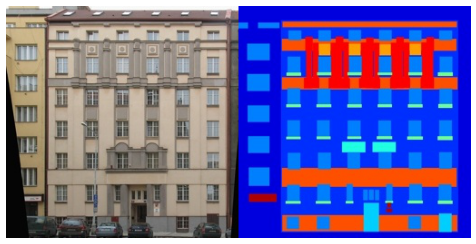

Facades paired image size: (256, 512)


In [15]:
# read the paired image
I = load_image('./facades/test/1.jpg')

visualize(I[0], 60)

# show the paired image size 
print(f'Facades paired image size: {I.size(2), I.size(3)}')

Note that this is a single image compresing a paire of images. On the left is a real-scene image (the groundd truth), and on the right is its corresponding semantic segmentation mask. We usually consider how to generate a photorealistic image from a mask, i.e., right -> left. 

In [16]:
%cd ..
!mkdir unpaired/
%cd unpaired/
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip --no-check-certificate
!unzip -qq horse2zebra.zip
!rm -f horse2zebra.zip

/content/data
/content/data/unpaired
--2022-03-29 03:40:57--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  15.8MB/s    in 18s     

2022-03-29 03:41:16 (6.08 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



Here, we have downloaded an unpaired dataset horse2zebra that contains unpaired images (two images, not concatenated). Let's look at the directory structure and visualize an example:

In [17]:
# show the directory structure
!tree horse2zebra

horse2zebra
├── testA
│   ├── n02381460_1000.jpg
│   ├── n02381460_1010.jpg
│   ├── n02381460_1030.jpg
│   ├── n02381460_1090.jpg
│   ├── n02381460_1100.jpg
│   ├── n02381460_1110.jpg
│   ├── n02381460_1120.jpg
│   ├── n02381460_1160.jpg
│   ├── n02381460_120.jpg
│   ├── n02381460_1210.jpg
│   ├── n02381460_1260.jpg
│   ├── n02381460_1300.jpg
│   ├── n02381460_1350.jpg
│   ├── n02381460_1360.jpg
│   ├── n02381460_140.jpg
│   ├── n02381460_1420.jpg
│   ├── n02381460_1540.jpg
│   ├── n02381460_1620.jpg
│   ├── n02381460_1630.jpg
│   ├── n02381460_1660.jpg
│   ├── n02381460_1690.jpg
│   ├── n02381460_1740.jpg
│   ├── n02381460_1750.jpg
│   ├── n02381460_180.jpg
│   ├── n02381460_1820.jpg
│   ├── n02381460_1830.jpg
│   ├── n02381460_1870.jpg
│   ├── n02381460_1920.jpg
│   ├── n02381460_200.jpg
│   ├── n02381460_2050.jpg
│   ├── n02381460_20.jpg
│   ├── n02381460_2100.jpg
│   ├── n02381460_2120.jpg
│   ├── n02381460_2150.jpg
│   ├── n02381460_2280.jpg
│   ├── n02381460_2460.jpg
│   ├── n023

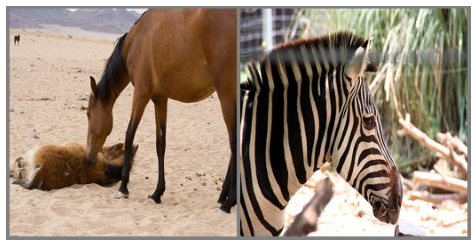

In [19]:
# read the unpaired image
img_horse = load_image('./horse2zebra/testA/n02381460_1110.jpg')
img_zebra = load_image('./horse2zebra/testB/n02391049_860.jpg')

visualize(torchvision.utils.make_grid(torch.cat((img_horse, img_zebra), dim=0), 2, 4), 60)

Note that these are two images that are unpaired (not concatenated).

In [20]:
# change the directory back to the root of MMEditing
%cd ../..
!ls

/content
data  sample_data


## Paired Image-to-Image Translation（pix2pix)

### Network Structure 

The difference between unconditional and conditional image generation is that the latter maps images to images, rather than the latent noise to images. Thus, in conditional image generation, the generator structure also includes an encoder that maps the image to the latent space.

**Pix2pix** first presents the "image-to-image translation" problem, and it uses paired training data. There are two choices for the architecture of the generator:

![pix2pixgenerator](https://drive.google.com/uc?export=view&id=196YecwMvEGlN02lztH7XnQG03izEhMgM)

on the left is a typical "encoder-decoder" generator, and on the right is the "U-Net" generator. The "U-Net" is an encoder-decoder with skip connections between mirrored layers in the encoder and decoder stacks. We mainly implement the "U-Net" generator in pix2pix, because it usually achieves better performance compared with the common "encoder-decoder" generator.


**U-Net** contains an encoder and a decoder.
* Encoder has N=8 downsampling convolutional layers
* Decoder has N=8 upsampling transposed convolutional layers
adding up to 16 layers, where the i-th layer and the (17-i)-th layer are connected

In [ ]:
class UnetGenerator(nn.Module):
    def __init__(self, num_downs=8, ngf=64):
        super(UnetGenerator, self).__init__()
        # the innermost two layers
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, None, innermost=True)
        # the middle six layers, with 512 channels
        for i in range(num_downs - 5)        :
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, unet_block, use_dropout=True)
        # each time add two outer layers, with the channel number halved
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, unet_block)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, unet_block)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, unet_block)
        # the outermost two layers, input 3 channels, output 3 channels
        self.model = UnetSkipConnectionBlock(3, ngf, unet_block, outermost=True)

    def forward(self, input):
        return self.model(input)


**UnetSkipConnectionBlock** defines two skip-connected layers, containing 
**convolutional layer** ---> inner UnetSkipConnectionBlocks--> **Transposed convolutional layer**
* submodule: inner UnetSkipConnectionBlocks--> input_nc + outer_nc
* channels:input_nc --> inner_nc --> outer_nc --> input_nc + outer_nc
* outermost: this block is the outermost layer
* innermost: this block is the innermost layer

